In [2]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-10-31-02-33-25/model-12.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-10-31-10-32-35/model-4.pt',
    'clvp2.pth': '',
    'diffusion.pth': '/home/hyc/tortoise_plus_zh/ttts/diffusion/logs/2023-10-27-00-00-28/model-12.pt',
    'vocoder.pth': '/home/hyc/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [5]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:1'
text = "大家好，今天来点大家想看的东西。"
# text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

da4 jia1 hao3 ， jin1 tian1 lai2 dian3 da4 jia1 xiang3 kan4 de5 dong1 xi1 。
tensor([[161,   2, 155,   2,  16,  87,   2,  43,   2, 224,   2, 171,  71,   2,
         182,   2, 188,   2, 161,   2, 155,   2,  62,  92,   2,  19,  63,   2,
          65,   2,  12,  84,   2, 228,   2,  39,   0]], device='cuda:1',
       dtype=torch.int32)


In [6]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '0.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

torch.Size([1, 100, 433])


In [7]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 2.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 433])
torch.Size([1, 37])


/home/hyc/miniconda3/envs/vocos/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


tensor([[  93,   31,  188,  188,   31,   86,    4,   15,    9,   96,   11,   26,
            9,   72,   96,    0,   30,   53,  101,   53,   32,  188,   86,    4,
           96,   44,   40,   86,    4,    4,   86,    4,   86,  115,   49,    4,
           96,   30,   31,   13,   53,   53,   53,   71,   32,  188,   93,    1,
           34,   53,   53,    4,   96,   30,   42,   44,   82,   86,   53,   53,
           32,   40,    4,   72,   96,  188,   12,    7,   11,   32,   26,    6,
            4,    4,   86,    4,    4,    4,   32,   93,   93,  188,  188, 8193]],
       device='cuda:1')


In [15]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False)
latent.shape

torch.Size([1, 84, 1024])

In [ ]:

mel = do_spectrogram_diffusion(diffusion, diffuser, latents, diffusion_conditioning, temperature=diffusion_temperature, 
                                                    verbose=verbose)
                        wav = vocoder.inference(mel)

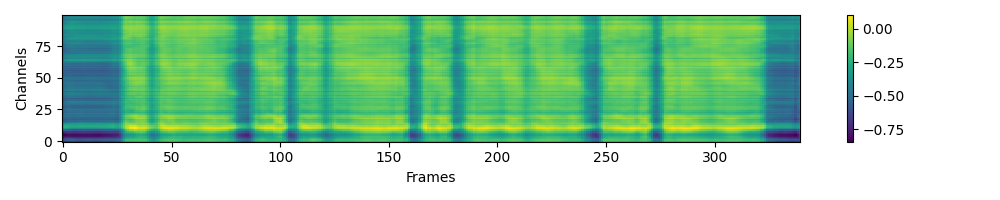

In [32]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [33]:
from ttts.vocoder.vocos import Vocos
from IPython.display import Audio
vocoder = Vocos.from_pretrained("/home/hyc/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","/home/hyc/tortoise_plus_zh/ttts/vocoder/config.yaml")
audio = vocoder.decode(mel.cpu())
torchaudio.save('gen_0.wav',audio,24000)
Audio('gen_0.wav')